In [1]:
train_counterfacts_data_url = "https://raw.githubusercontent.com/acmi-lab/counterfactually-augmented-data/master/sentiment/combined/paired/train_paired.tsv"
val_counterfacts_data_url = "https://raw.githubusercontent.com/acmi-lab/counterfactually-augmented-data/master/sentiment/combined/paired/dev_paired.tsv"


train_orig_data_url = "https://raw.githubusercontent.com/acmi-lab/counterfactually-augmented-data/master/sentiment/orig/eighty_percent/train.tsv"
test_orig_data_url = "https://raw.githubusercontent.com/acmi-lab/counterfactually-augmented-data/master/sentiment/orig/eighty_percent/test.tsv"




In [2]:
import sys, pandas as pd
import numpy as np
from functools import reduce 
from collections import Counter
pd.set_option('display.max_colwidth', 0)
sys.path.append("../src")
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from datetime import datetime

datefmt = datetime.now().strftime("%Y%m%d%H%M")



In [3]:
from utils.diff_dataset_counterfactuals import DiffDatasetCounterFactuals
from utils.diff_sentences import DiffSentences

# words  = DiffDatasetCounterFactuals().compare(train_counterfacts_data)

In [4]:
# words_all = reduce(lambda a, b: a+b, words)

In [5]:
# df_word_feq = pd.DataFrame(Counter(words_all).most_common())
# df_word_feq.columns = ["word", "freq"]
# df_word_feq

In [6]:
# df_word_feq.query("freq > 5").sort_values(by=["freq"], ascending = False).head(n=50)

In [7]:
# df_word_feq["freq"].plot.hist(bins=100, log=True)

In [8]:


def get_batch_id(df, df_counter_fact):
    dict_text_index = {}
    dict_batch_index = {}
    for r in df_counter_fact.to_dict('records'):
        dict_text_index[r["Text"]] = r["batch_id"]
        if  r["batch_id"] not in dict_batch_index: dict_batch_index[ r["batch_id"]] = {}
            
        counter_label = 'Negative' if r["Sentiment"] == 'Positive' else 'Positive'
        dict_batch_index[r["batch_id"]][counter_label] =  r["Text"]
    
    df["batch_id"] = df["Text"].apply(lambda x: dict_text_index.get(x, -1)).astype(int)
    df["counter_text"] = df.apply(lambda x: dict_batch_index.get(x["batch_id"], {}).get(x["Sentiment"], None), axis=1)
    df["counter_sentiment"] = df.apply(lambda x:('Negative' if x["Sentiment"] == 'Positive' else 'Positive')
                                       if x["counter_text"] else None , axis=1)
   



    return df

In [9]:
df_orig = pd.read_csv(train_orig_data_url, sep="\t")
df_orig

,Sentiment,Text,Length
0,Positive,Adrian Pasdar is excellent is this film. He makes a fascinating woman.,12
1,Positive,"This is the definitive movie version of Hamlet. Branagh cuts nothing, but there are no wasted moments.",17
2,Positive,"I don't know why I like this movie so well, but I never get tired of watching it.",18
3,Positive,"Obviously written for the stage. Lightweight but worthwhile. How can you go wrong with Ralph Richardson, Olivier and Merle Oberon.",20
4,Positive,"This movie will always be a Broadway and Movie classic, as long as there are still people who sing, dance, and act.",22
...,...,...,...
19257,Negative,"As someone who has both read the novel and seen the film, I have a different take on why the film was such a flop. First, any comparisons between novel and film are purely superficial. They are two different animals.<br /><br />The novel is probably intended as a satire, but it arrives as a cross between tragedy and polemic instead. Any comedic elements such as those which later formed the stylistic basis of the film version are merely incidental to the author's uniformly cynical thrust. And lest the omnipresent white suit of the author fool you into thinking this is another Mark Twain, think again. A more apt literary precedent would be the spectre of Ambrose Bierce in a top hat and tails. Tom Wolfe is equal parts clown and hack, more celebrity than author, always looking for new grist for his self-absorbed mill. <br /><br />It is therefore no wonder that the excellent production skills and direction lavished on the making of the film were doomed from the start. Unlike true satire, which translates very well into film, polemics are grounded not in universally accessible observations on some form or other of human behavior, but in a single-minded attack on specific people -- whether real or fictional straw men -- who have somehow earned the wrath of the writer. Any effort to create a successful filmed story or narrative from such a beginning must have a clean start, free of the writer's influence or interference.<br /><br />Having said that, I too find fault with the casting. It is not merely that incompetents like Bruce Willis and Melanie Griffith fail to measure up, but that real talents like Tom Hanks, F. Murray Abraham, and Morgan Freeman are either totally wasted or given roles that are mere caricatures.<br /><br />There is enough topical material here for a truly great film satire, but it fails to come even close.",317
19258,Negative,"Gung Ho was a good idea, however it is to much to ask Americans viewers to understand the dynamics of American jobs and foreign competition.In this movie the main character Hunt Stevenson(Michael Keaton) goes to Japan and convinces a Japanese auto company to come to America and help his dying Pennslyvania town. Two things come at you.First why would a Japanese company come to America to make cars when they do so ,and so well at that? Secondly can anyone understand that American companies of all types go to third world nations to have their products made to escape American labor costs? It makes the film's premise then that the Number one maker of cars in the world would go to one of its' top competitors(aside from Germany)and put a plant there as unrealistic. Keaton was still in his comedy mode by this time. But he gives a credible performance all the same as he could prove that he could go from comedy to drama in a matter of seconds and still not embarrass himself but Director Ron Howard can't keep this from becoming a TV movie which it ends up being anyway because they have to give the unlikely story a happy ending the politics and problems of Japanese and American relations not withstanding. Gung Ho has a Happy Days and Laverne and Shirley feel to it as the producers of both TV shows made the film and then made the TV version of this movie as well which gives the film its' lightweight feel.The Japanese manager gets to love his American workers and feels he and othe

In [10]:
df_counterfacts_train = pd.read_csv(train_counterfacts_data_url, sep="\t")
df_counterfacts_train.head()

,Sentiment,Text,batch_id
0,Negative,"Long, boring, blasphemous. Never have I been so glad to see ending credits roll.",4
1,Positive,"Long, fascinating, soulful. Never have I been so sad to see ending credits roll.",4
2,Negative,Not good! Rent or buy the original! Watch this only if someone has a gun to your head and then....maybe.<br /><br />It is like claiming an Elvis actor is as good as the real King.,40
3,Positive,"So good! Rent or buy the original, too! Watch this, too! It's just as good!<br /><br />It is an amazing Elvis impersonator and the real King.",40
4,Negative,"This movie is so bad, it can only be compared to the all-time worst ""comedy"": Police Academy 7. No laughs throughout the movie. Do something worthwhile, anything really. Just don't waste your time on this garbage.",47


In [11]:
df_counterfacts_val = pd.read_csv(val_counterfacts_data_url, sep="\t")
df_counterfacts_val.head()

,Sentiment,Text,batch_id
0,Negative,I saw this in the summer of 1990. I'm still annoyed by how bad this movie is in 2001.<br /><br />Implausible plot. You'd have to be a child to think this could happen.<br /><br />I'm just really annoyed by it. Don't see this.,122
1,Positive,I saw this in the summer of 1990. I'm still annoyed by how good this movie is in 2001.<br /><br />Incredible plot. You'd have to be a child to think this could happen.<br /><br />I'm just really annoyed by it. See this.,122
2,Negative,"The first half of the film is OK, the second half one of the most tedious experiences imaginable. Quite possibly the most overrated movie of all time. ""Pulp Fiction"" was robbed for ""Best Picture."" This is one of those films that people feel required to love because the main character is ""slow.""",284
3,Positive,"The first half of the film is good, the second half one of the most wonderful experiences imaginable. Quite possibly the most underrated movie of all time. ""Pulp Fiction"" rightfully lost for ""Best Picture."" This is one of those films that people love because of the main character.",284
4,Negative,"This movie is not very good.In fact, it is the worst Elvis movie I have seen.It has very little plot,mostly partying,beer drinking and fighting. Burgess Meredith and Thomas Gomez are wasted. I don't know why they did this movie.You could say Elvis was wasted as well,he is much,much better in ""Follow That Dream.""",310


In [12]:
df_counterfacts_train.shape

(3414, 3)

In [13]:
df_orig = df_orig.pipe(get_batch_id, df_counterfacts_train)

In [14]:

df_orig_train, df_orig_val = train_test_split(df_orig, test_size=0.2, random_state=42)
df_orig_train.shape, df_orig_val.shape

((15409, 6), (3853, 6))

In [15]:
df_orig_train.sample(n=10)

,Sentiment,Text,Length,batch_id,counter_text,counter_sentiment
17343,Negative,"There are similarities between Ray Lawrence's ""Jindabyne"" and his last movie ""Lantana""  a dead body and its repercussions for already dysfunctional lives. But whereas ""Lantana"" offered some hope and resolution, ""Jindabyne"" leaves everything unresolved in a bleak way that will leave most viewers unsatisfied, perhaps even cheated.<br /><br />The storyline - the aftermath of a fisherman's discovery of a corpse floating in a remote river - is based on a short story by Raymond Carver. It became an element in Robert Altman's classic 1993 ensemble ""Short Cuts"". Lawrence uses this theme for an exploration and exposition of relationships within a small Australian community under stress. The movie poses some moral questions ""Would you let the discovery of a dead body ruin your good weekend?"" and more poignantly for Australians ""Would it make any difference if the dead person was an aboriginal?"" The acting, especially by Gabriel Byrne and Laura Linney, is commendable. And there are elements of mysticism reinforced by haunting music, not unlike ""Picnic at Hanging Rock"".<br /><br />If all this sounds like the basis for a great movie - be prepared for a let down, the pace is very slow and the murder is shown near the beginning, thereby eliminating the element of mystery. And so we are left with these desolate lives and a blank finale.",220,-1,None,None
92,Positive,"Michael Is King. This film contains some of the best stuff Mike has ever done. Smooth Criminal is pure genius. The cameos are wonderful, but as always, the main event is MJ himself. He is the best, hands down.",39,-1,None,None
14152,Negative,please don't rent or even think about buying this movie.they don't even have it available at the red box to rent which would cost a $1 & i think its worth less than that.the main reason why i rented this d movie was because Jenna Jameson is in the movie lol between 2-5 min.i will give credit that the movie had hot chicks and quite a bit of nudity but other than that you might as well buy another d horror movie that has the same thing with nobody you know.Ginger Lynn has more acting time in this movie than Jenna & she's not even on the front cover of the movie nor her name.i recommend people to watch zombie strippers because you see Jenna almost throughout the whole movie & nude most of the time.this movie is a big disappointment & such a huge waste of time.,148,-1,None,None
1874,Positive,"Another one of those films you hear about from friends (...or read about on IMDb). Not many false notes in this one. I could see just about everything here actually happening to a young girl fleeing from a dead-end home town in Tennessee to Florida, with all her worldly possessions in an old beaten-up car.<br /><br />The heroine, Ruby, makes some false starts, but learns from them. I found myself wondering why, why didn't she lean a bit more on Mike's shoulder, but...she has her reasons, as it turns out.<br /><br />Just a fine film. The only thing I don't much like about it, I think, is the title.",109,-1,None,None
16562,Negative,"This movie is another one on my List of Movies Not To Bother With. Saw it 40 years ago as an adolescent, stayed up late to do so, was very annoyed to find that it was about 95% romance,4% everything else, 1% history if that. It's what I call a bait and switch movie, one with an interesting title, the actual movie is a scam. This is a subject which deserves a good cinematic treatment, this movie is almost an insult to those who served. The actual members of the Lafayette Escadrille were not on the run from the law nor were they the products of abusive homes, they were in reality idealists who wanted to do something to help France. And I suspect many of them came from a more upper class background than Tab Hunter's character. Flying school is not for the smart alecks and the know it alls, an individual such as the one portrayed here wouldn

In [16]:
(df_orig_train["batch_id"]!=-1).value_counts()

False    14020
True     1389 
Name: batch_id, dtype: int64

In [17]:
df_orig_train[df_orig_train["batch_id"]==-1]

,Sentiment,Text,Length,batch_id,counter_text,counter_sentiment
4448,Positive,"I love this anime! I was laughing my head off with all of the jokes and the violence (mostly from Akane Ranma's reluctant but short tempered ""fiancee"")is so slapstick however Ranma does deserve it but he does try his best to make amends...clumsily. The main character Ranma goes to China to train only to fall into the cursed Jusenkkyo Spring and turns into a girl when splashed by cold water. From then on it's pure chaos one after another. Among the stand outs are the deranged brother and sister duo of Kuno and Kodachi, the sexy Shampoo, the pervert Happosai all causing trouble for our hero/heroine. However it is Ranma's selfish father Genma who winds up being the culprit for the mess most of the time. If anyone want an anime that's funny, this is the one. It's cuter and better with the Japanese dub.",145,-1,None,None
4132,Positive,"Melvyn Douglas once more gives a polished performance in which, this time, he inhabits the role of a detective who can't place love before duty and adventure, and the warmly beautiful Joan Blondell (who, far from being illiterate, as one reviewer suggested, wrote a novel about her early life) is as enjoyable as ever as his ever-suffering sweetheart.It's almost a screwball comedy, almost a Thin Man-type movie, almost a series, I guess, that didn't quite make it to a sequel. It doesn't quite reach classic status, but it has all the ingredients for a fun 85 minutes with an episodic but pacey script, fine character actors, and direction that keeps it all moving fast enough so that you nearly don't notice that Williams (Douglas) isn't exactly Columbo when it comes to detecting. I wish there were more films like this.",140,-1,None,None
7007,Positive,"First of all, this film was not released to theatres (TESTED POORLY THEY SAY),I say they figured the story of crooked cops, politicians & dedicated newspaper people had been done to death,just send it DVD & cable TV> & take the money & run.<br /><br />That being said I usually like this type of movie, especially with this named cast. Morgan Freeman, Justin Timberlake, Kevin Spacey,<br /><br />L.L.Cool J, Cary Elways, John Heard & on the distaff side, Piper Perabo & Roslyn Sanchez.<br /><br />The plot & story have been done to death, BUT the above cast brings life to this violent movie & it is actually watchable.<br /><br />Justin Timberlake Is good as the dedicated young reporter for a throw-away newspaper edited by Morgan Freeman, The others are either crooked Cops,& Politicians or somewhat decent guys, The 2 ladies are the girl friends of LL COOL J & JUSTIN TIMBERLAKE & do whats required, It is quite violent, many killings etc, not for children. By no means is the a great film, BUT for what it is & the cast It is definitely good,<br /><br />Ratings *** (out of 4) 86 points (out of 100) IMDb 8 (out of 10)",201,-1,None,None
11838,Negative,"I had the displeasure of watching this movie with my girlfriend, who, like me, is a fan of the first. This movie down right sucked! It lacked the magic of the first. You could actually understand every word the mice said, the animation is crappy, the palace is much much different from the first movie, there's new characters that were never mentioned before and were terrible, luckily the Prince didn't have many lines which kept him from sounding stupid. Basically its like The Lion King 1 1/2 except its different stories all told by the mice. The reason I'm giving this a 2 out of 10 is because the songs not sung by the characters were the most enjoyable.",119,-1,None,None
5689,Positive,"It is written in stone that Disney animations simply ~must~ be musicals. Right? Where? Show me. Because I found this attempt to be much more enjoyable for ~not~ containing the hokey made-for-five-year-old standard Disney musical fare. <br /><br />While the story was not as enthralling as it could have been, it was still quite good, enjoyable, and adventurous. I had 

In [18]:
df_orig_train[df_orig_train["Text"].isin(df_orig_train["counter_text"])]

,Sentiment,Text,Length,batch_id,counter_text,counter_sentiment
1406,Positive,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",93,13959,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",Negative
1404,Positive,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",93,13959,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",Negative
18135,Negative,"Primal Species comes from B Movie legend Roger Corman and as such everybody who watches this needs to realise that this is a Low Budget B Movie and it knows it.<br /><br />A bunch of terrorists high-jack a Lorry and kill an entire army doing so, they believe it to hold uranium, but No..... It contains two Dino's with a taste for Human Flesh... Then a Crack team, who might as well be called Delta Force get called in.<br /><br />OK, This ain't Jurassic Park, and Yes The Dino's are never clearly seen because it's obviously a guy in a Costume that's not too dissimilar to Barney the Dinosaur - only slightly LESS terrifying,but come on guys this had about 1% of Jurassic Park's Budget and as such does what it can.<br /><br />Does this deserve to be in the bottom 100?....HELL NO!!! I think the nearly half of voters who give this a 1 - are being WAY WAY overly harsh, it's much closer to a 4... it's actually a lot better than a whole host of other movies not in the Bottom 100, and has a similar production value to a Sci-Fi Channel Production. (again Movies which get a overly harsh time from critics here on IMDb)<br /><br />The acting is as expected in a B Movie although none of the actors take it that seriously, neither does the script<br /><br />All in All it's an enjoyable B Movie - Not for Film Snobs<br /><br />** out of *****",251,8822,"Primal Species comes from B Movie legend Roger Corman and as such everybody who watches this needs to realise that this is a Low Budget B Movie and it knows it.<br /><br />A bunch of terrorists high-jack a Lorry and kill an entire army doing so, they believe it to hold uranium, but No..... It contains two Dino's with a tas

In [19]:
df_orig_train[df_orig_train["counter_text"].isin(df_orig_train["Text"])]

,Sentiment,Text,Length,batch_id,counter_text,counter_sentiment
1406,Positive,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",93,13959,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",Negative
1404,Positive,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",93,13959,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",Negative
18135,Negative,"Primal Species comes from B Movie legend Roger Corman and as such everybody who watches this needs to realise that this is a Low Budget B Movie and it knows it.<br /><br />A bunch of terrorists high-jack a Lorry and kill an entire army doing so, they believe it to hold uranium, but No..... It contains two Dino's with a taste for Human Flesh... Then a Crack team, who might as well be called Delta Force get called in.<br /><br />OK, This ain't Jurassic Park, and Yes The Dino's are never clearly seen because it's obviously a guy in a Costume that's not too dissimilar to Barney the Dinosaur - only slightly LESS terrifying,but come on guys this had about 1% of Jurassic Park's Budget and as such does what it can.<br /><br />Does this deserve to be in the bottom 100?....HELL NO!!! I think the nearly half of voters who give this a 1 - are being WAY WAY overly harsh, it's much closer to a 4... it's actually a lot better than a whole host of other movies not in the Bottom 100, and has a similar production value to a Sci-Fi Channel Production. (again Movies which get a overly harsh time from critics here on IMDb)<br /><br />The acting is as expected in a B Movie although none of the actors take it that seriously, neither does the script<br /><br />All in All it's an enjoyable B Movie - Not for Film Snobs<br /><br />** out of *****",251,8822,"Primal Species comes from B Movie legend Roger Corman and as such everybody who watches this needs to realise that this is a Low Budget B Movie and it knows it.<br /><br />A bunch of terrorists high-jack a Lorry and kill an entire army doing so, they believe it to hold uranium, but No..... It contains two Dino's with a tas

In [20]:
df_orig_train.query("Text == counter_text")

,Sentiment,Text,Length,batch_id,counter_text,counter_sentiment
1406,Positive,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",93,13959,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",Negative
1404,Positive,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",93,13959,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",Negative
18135,Negative,"Primal Species comes from B Movie legend Roger Corman and as such everybody who watches this needs to realise that this is a Low Budget B Movie and it knows it.<br /><br />A bunch of terrorists high-jack a Lorry and kill an entire army doing so, they believe it to hold uranium, but No..... It contains two Dino's with a taste for Human Flesh... Then a Crack team, who might as well be called Delta Force get called in.<br /><br />OK, This ain't Jurassic Park, and Yes The Dino's are never clearly seen because it's obviously a guy in a Costume that's not too dissimilar to Barney the Dinosaur - only slightly LESS terrifying,but come on guys this had about 1% of Jurassic Park's Budget and as such does what it can.<br /><br />Does this deserve to be in the bottom 100?....HELL NO!!! I think the nearly half of voters who give this a 1 - are being WAY WAY overly harsh, it's much closer to a 4... it's actually a lot better than a whole host of other movies not in the Bottom 100, and has a similar production value to a Sci-Fi Channel Production. (again Movies which get a overly harsh time from critics here on IMDb)<br /><br />The acting is as expected in a B Movie although none of the actors take it that seriously, neither does the script<br /><br />All in All it's an enjoyable B Movie - Not for Film Snobs<br /><br />** out of *****",251,8822,"Primal Species comes from B Movie legend Roger Corman and as such everybody who watches this needs to realise that this is a Low Budget B Movie and it knows it.<br /><br />A bunch of terrorists high-jack a Lorry and kill an entire army doing so, they believe it to hold uranium, but No..... It contains two Dino's with a tas

In [21]:
def _compute_affablity_rate(samples, threshold):
    aff_diff = DiffSentences().pairwise_edit_distance_ratio(list(samples), list(samples), score_cutoff=0)
    
    # Set max distance in diagnoals so that it doesnt come up as the closest match
    for i in range(len(aff_diff)):
        aff_diff[i,i]=1000
    
    closest_match = np.min(aff_diff, axis=-1)
    closest_match_idx = np.argmin(aff_diff, axis=-1)
    aff_diff_min = [ 1 for i in closest_match if i < threshold ]
    aff_rate = sum(aff_diff_min) / len(samples)
    
    debug_df = pd.DataFrame(samples)
    debug_df["closest_dist"] = closest_match
    debug_df["closest_match"] = [list(samples)[i] for i in closest_match_idx]
    
    return aff_rate, debug_df
    
def _compute_adv_rate(samples1, samples2, threshold):
    adv_diff = DiffSentences().pairwise_edit_distance_ratio(list(samples1), list(samples2), score_cutoff=0)

    closest_match = np.min(adv_diff, axis=-1)
    closest_match_idx = np.argmin(adv_diff, axis=-1)
    
    # Adv P -> N debug info
    debug_df = pd.DataFrame(samples1)
    debug_df["closest_dist"] = closest_match
    debug_df["closest_match"] = [list(samples2)[i] for i in closest_match_idx]
    
    adv_diff_min = [ 1 for i in closest_match if i < threshold ]
    adv_rate = sum(adv_diff_min) / len(samples1)
    
    return adv_rate, debug_df

    
def get_stats(df, threshold_adv=.25, threshold_aff=.50):
    num_unique = df["Text"].nunique()
    pos_ratio = len(df.query("Sentiment == 'Positive'"))/len(df)
    pos_texts = df.query("Sentiment == 'Positive'")["Text"]
    neg_texts = df.query("Sentiment == 'Negative'")["Text"]

    pos_adv_rate, adv_debug = _compute_adv_rate(pos_texts, neg_texts, threshold_adv)
    pos_aff_rate, aff_pos_debug = _compute_affablity_rate(pos_texts, threshold_aff)

    neg_aff_rate, neg_pos_debug = _compute_affablity_rate( neg_texts, threshold_aff)


        
    result = {
        "Unique" : num_unique,
        "PosRate": pos_ratio,
        "AdvRatePN" : pos_adv_rate,
        "AffRateP": pos_aff_rate,
        "AffRateN": neg_aff_rate,
        "Total" : len(df)
    }
    
    debug = {
        "adv_p_n" : adv_debug,
        "aff_p" : aff_pos_debug,
        "aff_n" : neg_pos_debug
    }
    
    
    return result, debug

In [22]:
%%time

counterfact_stats, counterfact_debug = get_stats(df_counterfacts_train)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aparnaelangovan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aparnaelangovan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aparnaelangovan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


CPU times: user 8min 35s, sys: 4.4 s, total: 8min 40s
Wall time: 8min 46s


In [23]:
counterfact_stats

{'Unique': 3413,
 'PosRate': 0.5,
 'AdvRatePN': 0.929701230228471,
 'AffRateP': 0.0,
 'AffRateN': 0.0,
 'Total': 3414}

/Users/aparnaelangovan/PycharmProjects/venv/large-scale-ptm-ppi/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


(0.0, 1.2)

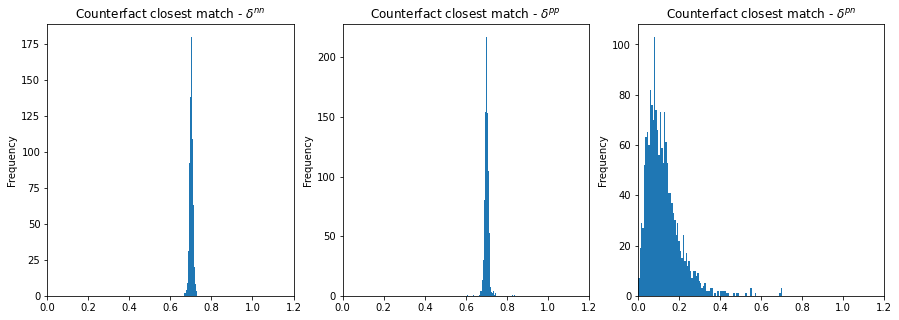

In [24]:
_, ax = plt.subplots(1,3,  figsize=(15,5))


counterfact_debug["aff_n"]["closest_dist"].plot.hist(bins=100, ax=ax[0],  title = "Counterfact closest match - $\delta^{nn}$")
ax[0].set_xlim(0, 1.2)

counterfact_debug["aff_p"]["closest_dist"].plot.hist(bins=100, ax=ax[1],  title = "Counterfact closest match - $\delta^{pp}$")
ax[1].set_xlim(0, 1.2)


counterfact_debug["adv_p_n"]["closest_dist"].plot.hist(bins=100, ax=ax[2],  title = "Counterfact closest match - $\delta^{pn}$")
ax[2].set_xlim(0, 1.2)


In [25]:
def prep_counterfactual(df, adv_rate_pos=0.1, total_size=3400):
    
    pos_rate = 0.5
    
    neg_samples = int(total_size * (1-pos_rate))
    

    pos_samples = total_size - neg_samples
    adv_neg_samples = int(adv_rate_pos * pos_samples)
    non_adv_neg_samples = neg_samples - adv_neg_samples
    
    
    df_pos_with_cf = df.query("batch_id != -1 and Sentiment == 'Positive'")
    
    # Get n positives
    pos_samp_with_adv_size = min(len(df_pos_with_cf), pos_samples)
    df_pos_with_adv = df_pos_with_cf.sample(n=pos_samp_with_adv_size)
    df_pos_without_adv = df.query("batch_id == -1 and Sentiment == 'Positive'")\
                [["Sentiment", "Text", "batch_id"]].sample(n=pos_samples - pos_samp_with_adv_size)


        
    # Get paired n negatives
    df_paired = df_pos_with_adv.sample(n=adv_neg_samples)
    df_adv_neg = df_paired[["counter_sentiment", "counter_text" , "batch_id" ]]
    df_adv_neg.columns = ["Sentiment", "Text", "batch_id"]

    # Random neg
    df_neg_random = df.query("batch_id == -1 and Sentiment == 'Negative'")\
                    [["Sentiment", "Text", "batch_id"]].sample(n=non_adv_neg_samples).copy()
    
    return pd.concat([df_adv_neg, df_pos_with_adv[["Sentiment", "Text", "batch_id"]] ,
                      df_pos_without_adv, df_neg_random])

    
    
    


In [26]:
%%time

ADV_R_PN = 0.0

df_train_prepared = prep_counterfactual(df_orig_train, adv_rate_pos=ADV_R_PN, total_size=3400)   

result_train_stats, train_debug = get_stats(df_train_prepared, threshold_adv=0.25, threshold_aff=0.50)
print(result_train_stats)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aparnaelangovan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aparnaelangovan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aparnaelangovan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


{'Unique': 3396, 'PosRate': 0.5, 'AdvRatePN': 0.0, 'AffRateP': 0.0058823529411764705, 'AffRateN': 0.0, 'Total': 3400}
CPU times: user 9min 12s, sys: 9.56 s, total: 9min 22s
Wall time: 9min 36s


In [27]:
%%time

df_val_prepared = prep_counterfactual(df_orig_val, adv_rate_pos=ADV_R_PN, total_size=int(3400*0.2)  )

result_val_stats, val_debug = get_stats(df_val_prepared, threshold_adv=0.25, threshold_aff=0.50)
print(result_val_stats)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aparnaelangovan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aparnaelangovan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aparnaelangovan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


{'Unique': 680, 'PosRate': 0.5, 'AdvRatePN': 0.0, 'AffRateP': 0.0, 'AffRateN': 0.0, 'Total': 680}
CPU times: user 23.6 s, sys: 338 ms, total: 23.9 s
Wall time: 24.3 s


/Users/aparnaelangovan/PycharmProjects/venv/large-scale-ptm-ppi/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


(0.0, 1.2)

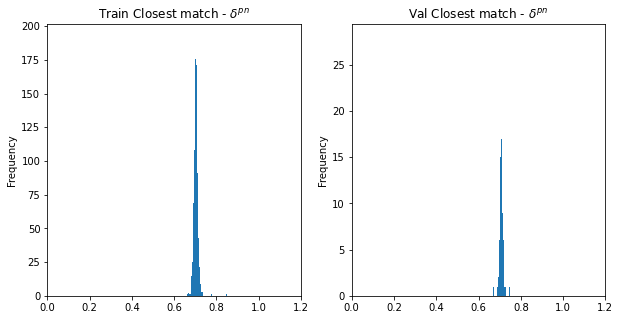

In [28]:
_, ax = plt.subplots(1,2, figsize=(10,5))
train_debug["adv_p_n"]["closest_dist"].plot.hist(bins=100, ax=ax[0], title = "Train Closest match - $\delta^{pn}$")
ax[0].set_xlim(0, 1.2)

val_debug["adv_p_n"]["closest_dist"].plot.hist(bins=100, ax=ax[1], title = "Val Closest match - $\delta^{pn}$")
ax[1].set_xlim(0, 1.2)

(0.0, 1.2)

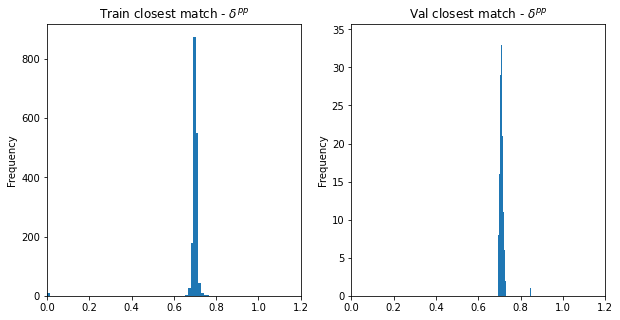

In [29]:
_, ax = plt.subplots(1,2,  figsize=(10,5))


train_debug["aff_p"]["closest_dist"].plot.hist(bins=100, ax=ax[0],  title = "Train closest match - $\delta^{pp}$")
ax[0].set_xlim(0, 1.2)

val_debug["aff_p"]["closest_dist"].plot.hist(bins=100, ax=ax[1], title = "Val closest match - $\delta^{pp}$")
ax[1].set_xlim(0, 1.2)

(0.0, 1.2)

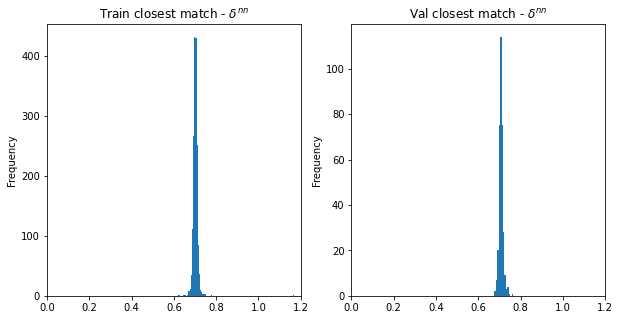

In [30]:
_, ax = plt.subplots(1,2,  figsize=(10,5))


train_debug["aff_n"]["closest_dist"].plot.hist(bins=100, ax=ax[0],  title = "Train closest match - $\delta^{nn}$")
ax[0].set_xlim(0, 1.2)

val_debug["aff_n"]["closest_dist"].plot.hist(bins=100, ax=ax[1], title = "Val closest match - $\delta^{nn}$")
ax[1].set_xlim(0, 1.2)



In [34]:
import sagemaker, io, json


def upload_df_to_s3(df, s3_dest):
    b = io.StringIO()
    df.to_json(b)
    
    print(f"Uploading {s3_dest}")
    
    sagemaker.s3.S3Uploader.upload_string_as_file_body(b.getvalue(), s3_dest)
    
def upload_json_to_s3(json_obj, s3_dest):
    b = io.StringIO()
    json.dump(json_obj, b)
    
    print(f"Uploading {s3_dest}")
    
    sagemaker.s3.S3Uploader.upload_string_as_file_body(b.getvalue(), s3_dest)
 
s3_prefix =  "s3://aegovan-data/counterfactuals/imdb/{}/{}_{}_{}".format(datefmt,
                                                                    int(result_train_stats["AdvRatePN"]*100)
                                                                    , int(result_train_stats["AffRateP"]*100)
                                                                    ,int(result_train_stats["AffRateN"]*100))

upload_df_to_s3(df_train_prepared.reset_index(),   f"{s3_prefix}/train.json")
upload_json_to_s3(result_train_stats,   f"{s3_prefix}/stats/train_stats.json")

upload_df_to_s3(df_val_prepared.reset_index(),   f"{s3_prefix}/val.json")
upload_json_to_s3(result_val_stats,   f"{s3_prefix}/stats/val_stats.json")

upload_df_to_s3( pd.read_csv(test_orig_data_url, sep="\t"), f"{s3_prefix}/test.json")

Uploading s3://aegovan-data/counterfactuals/imdb/202304091342/0_0_0/train.json
Uploading s3://aegovan-data/counterfactuals/imdb/202304091342/0_0_0/stats/train_stats.json
Uploading s3://aegovan-data/counterfactuals/imdb/202304091342/0_0_0/val.json
Uploading s3://aegovan-data/counterfactuals/imdb/202304091342/0_0_0/stats/val_stats.json
Uploading s3://aegovan-data/counterfactuals/imdb/202304091342/0_0_0/test.json


In [35]:
upload_df_to_s3(df_counterfacts_train,   f"s3://aegovan-data/counterfactuals/imdb/{datefmt}/original/train.json")
upload_json_to_s3(counterfact_stats,   f"s3://aegovan-data/counterfactuals/imdb/{datefmt}/original/train_stats.json")


upload_df_to_s3(df_counterfacts_val,   f"s3://aegovan-data/counterfactuals/imdb/{datefmt}/original/val.json")

Uploading s3://aegovan-data/counterfactuals/imdb/202304091342/original/train.json
Uploading s3://aegovan-data/counterfactuals/imdb/202304091342/original/train_stats.json
Uploading s3://aegovan-data/counterfactuals/imdb/202304091342/original/val.json


In [36]:
df_train_prepared.reset_index().sample(n=10).to_json("sample_counterfact_imdb.json")